In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [26]:
demand_data = pd.read_csv('data\dataset\demand.csv')
vehicle_data = pd.read_csv('data/dataset/vehicles.csv')
vehicle_fuels = pd.read_csv('data/dataset/vehicles_fuels.csv')
fuels_data = pd.read_csv('data/dataset/fuels.csv')
carbon_emissions_data = pd.read_csv('data/dataset/carbon_emissions.csv')
cost_profiles = pd.read_csv('data/dataset/cost_profiles.csv')

In [27]:
df_submission = pd.read_csv('grading_file/submission_14.csv')
unique_year = np.unique(df_submission['Year'])
coef = np.array([ 4.51451197e-04,  3.22017751e+00, -1.09844901e-01,  1.00008622e+00,
       -3.96969868e-04])
intercept = 0

In [28]:
df_fleet = {'ID':[],
            'qty': []}

dict_cost_buy = {}
dict_cost_ins = {}
dict_cost_mnt = {}
dict_cost_fuel = {}
dict_cost_sell = {}
dict_fleet = {}
for i in unique_year:
    dict_cost_buy[i] = 0
    dict_cost_ins[i] = 0
    dict_cost_mnt[i] = 0
    dict_cost_fuel[i] = 0
    dict_cost_sell[i] = 0
    dict_fleet[i] = {}

for i in range(len(df_submission)):
    use_type = df_submission['Type'].iloc[i]
    year = df_submission['Year'].iloc[i]
    qty = df_submission['Num_Vehicles'].iloc[i]
    veh_id = df_submission['ID'].iloc[i]
    dist = df_submission['Distance_per_vehicle(km)'].iloc[i]
    fuel = df_submission['Fuel'].iloc[i]
    
    if use_type == 'Buy':
        df_fleet['ID'].append(veh_id)
        df_fleet['qty'].append(qty)

        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh_id]
        cost_buy = cost_buy['Cost ($)'].iloc[0]
        dict_cost_buy[year] = dict_cost_buy[year] + cost_buy*qty
        if i < len(df_submission)-1:
            use_type_next = df_submission['Type'].iloc[i+1]
            if (use_type_next == 'Use') & (use_type == 'Buy'):
                dict_fleet[year]['ID'] = df_fleet['ID'].copy()
                dict_fleet[year]['qty'] = df_fleet['qty'].copy()
        
    elif use_type == 'Sell':
        temp_list = np.array(df_fleet['ID'])
        idx = np.where(temp_list == veh_id)
        idx = idx[0][0]
        df_fleet['qty'][idx] = df_fleet['qty'][idx] - qty
        if df_fleet['qty'][idx] == 0:
            del df_fleet['qty'][idx]
            del df_fleet['ID'][idx]
        year_buy = veh_id.split('_')
        year_buy = int(year_buy[-1])
        delta_year = year - year_buy + 1
        temp_df = cost_profiles.loc[cost_profiles['End of Year'] == delta_year]
        pct_resale = temp_df['Resale Value %'].iloc[0]/100
        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh_id]
        cost_buy = cost_buy['Cost ($)'].iloc[0]
        cost_sell = pct_resale*cost_buy
        dict_cost_sell[year] = dict_cost_sell[year] + cost_sell*qty
    
    else:
        #cost fuel
        temp_df = vehicle_fuels.loc[vehicle_fuels['ID'] == veh_id]
        consumption_unit = temp_df.loc[(temp_df['Fuel'] == fuel)]
        consumption_unit = consumption_unit['Consumption (unit_fuel/km)'].iloc[0]
        cost_per_fuel = fuels_data.loc[(fuels_data['Fuel'] == fuel) & (fuels_data['Year'] == year)]
        cost_per_fuel = cost_per_fuel['Cost ($/unit_fuel)'].iloc[0]
        dict_cost_fuel[year] = dict_cost_fuel[year] + consumption_unit*cost_per_fuel*dist*qty
#cost mnt and ins
for i in unique_year:
    temp_df = dict_fleet[i]
    for j in range(len(temp_df['ID'])):
        veh = temp_df['ID'][j]
        qty = temp_df['qty'][j]
        year_buy = veh.split('_')
        year_buy = int(year_buy[-1])
        delta_year = i - year_buy + 1
        temp_df2 = cost_profiles.loc[cost_profiles['End of Year'] <= delta_year]
        pct_ins = temp_df2['Insurance Cost %'].iloc[-1]/100
        pct_mnt = temp_df2['Maintenance Cost %'].iloc[-1]/100

        cost_buy = vehicle_data.loc[vehicle_data['ID'] == veh]
        cost_buy = cost_buy['Cost ($)'].iloc[0]

        dict_cost_ins[i] = dict_cost_ins[i] + pct_ins*cost_buy*qty
        dict_cost_mnt[i] = dict_cost_mnt[i] + pct_mnt*cost_buy*qty
    


In [29]:
new_arr_cost_buy= [i for i in dict_cost_buy.values()]
new_arr_cost_ins = [i for i in dict_cost_ins.values()]
new_arr_cost_mnt = [i for i in dict_cost_mnt.values()]
new_arr_cost_fuel = [i for i in dict_cost_fuel.values()]
new_arr_cost_sell = [i for i in dict_cost_sell.values()]
new_arr_total_cost = coef[0]*np.array(new_arr_cost_buy) + coef[1]*np.array(new_arr_cost_ins) + coef[2]*np.array(new_arr_cost_mnt) + coef[3]*np.array(new_arr_cost_fuel) + coef[4]*np.array(new_arr_cost_sell) 

new_grade_private = sum(new_arr_total_cost[:6]) + intercept
new_grade_public = sum(new_arr_total_cost)
new_private_score = 100 - 70*new_grade_private/65000000
new_public_score = 100 - 70*new_grade_public/172000000

df_cost = pd.DataFrame({'year': unique_year,
                        'cost_buy': new_arr_cost_buy,
                        'cost_ins': new_arr_cost_ins,
                        'cost_mnt': new_arr_cost_mnt,
                        'cost_fuel': new_arr_cost_fuel,
                        'cost_sell': new_arr_cost_sell})
# df_cost.to_csv('df_cost.csv')

In [30]:
new_grade_private

52013323.14050815

In [31]:
new_private_score, new_public_score

(43.98565200252968, 29.502484397174726)

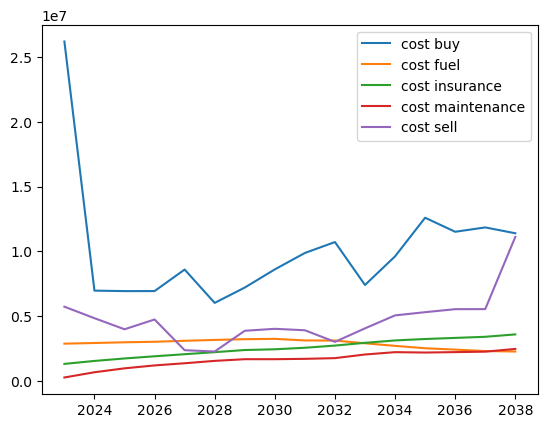

In [32]:
plt.plot(unique_year,dict_cost_buy.values())
plt.plot(unique_year,dict_cost_fuel.values())
plt.plot(unique_year,dict_cost_ins.values())
plt.plot(unique_year,dict_cost_mnt.values())
plt.plot(unique_year,dict_cost_sell.values())
plt.legend(['cost buy','cost fuel', 'cost insurance','cost maintenance','cost sell'])
plt.show()